# OK  pour ECL 21-22 (use this also for CPE next year !)
# clustering de News : K-Means sur SVD

In [1]:
import os, sys
print(os.getcwd())
print(sys.version)

e:\3A\Apprentissage bayésien\BE Traitement Texte
3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]


### Pour trouver la version (et le path) du python utilisé pour trouver quel pip appliquer


In [2]:
# pour trouver la version (et le path) du python utilisé pour trouver quel pip appliquer
!ps -ef | grep 'jupyter-lab' | grep python | grep -v grep
# 501 67449  2138   0  1:38   ttys001    0:15.28 /Users/alexandresaidi/opt/anaconda3/bin/python3.8 /Users/alexandresaidi/opt/anaconda3/bin/jupyter-lab 


  503  4636   726   0  3:19   ttys004    0:02.51 /usr/local/Cellar/python@3.9/3.9.10/Frameworks/Python.framework/Versions/3.9/Resources/Python.app/Contents/MacOS/Python /Users/alex1/VirtEnv39-folder/virtenv39/bin/jupyter-lab


## Importantion des packages et qq ajouts pour amélirer les sorties ..

In [22]:
if False :
    !pip install sklearn
    !pip install nltk
    
    # Ces packages sont pou rle cloud de points plus bas ! 
    !# si umap est déjà installé
    !pip uninstall umap # si installé MAIS ON PEUT LE GARDER AUSSI
    !pip install umap-learn 
    !pip install 'umap-learn==0.3.10' # Sinon, message d'erreur de version
    !pip install numba==0.53 # Sinon, message d'erreur de version

  Using cached umap-0.1.1.tar.gz (3.2 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3566 sha256=6a17d61d098feda5271993398e8771759786d1ba3b643ddadf5ca54087c004fb
  Stored in directory: /Users/alex1/Library/Caches/pip/wheels/72/1e/42/a9322736ec046a637487005e6b84c94617d9ac0bdb5159eeb7
Successfully built umap
You should consider upgrading via the '/Users/alex1/VirtEnv39-folder/virtenv39/bin/python -m pip install --upgrade pip' command.


In [2]:
### Il y a quelques "perles" Python qui facilitent les choses !!!

# from __future__ import print_function

from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from sklearn.cluster import KMeans, MiniBatchKMeans

import logging
from optparse import OptionParser
import sys
from time import time

import numpy as np


# Barre de progrès des calculs
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s %(message)s')

# QQ paramètres qu'on peut donner via :
#op = OptionParser()
#op.add_option("--lsa",
#              dest="n_components", type="int",
#              help="Preprocess documents with latent semantic analysis.")
# etc...

# 'n_components': None, 
# 'minibatch': True, 
# 'use_idf': True, 
# 'use_hashing': True, 
# 'n_features': 10000, 
# 'verbose': False}>, [])

## Chargement des données

In [3]:
# #############################################################################
# Chargeons QQ catégories de discussion depuis l'ensemble d'apprentissage
# avec des labels 0/1
categories = [
    'alt.atheism',
    'talk.religion.misc',
    'comp.graphics',
    'sci.space'
]
categories_bis  = [
            #'comp.graphics',
             #'comp.sys.linux.hardware',
             'comp.os.ms-windows.misc',
             'comp.sys.ibm.pc.hardware',
             'comp.sys.mac.hardware',
             'comp.windows.x'
    ]
# Si décommenté, on fera Toutes les catégoroes !
# categories = None

print("Loading 20 newsgroups dataset for categories:")

# Voir les imports
# dataset = fetch_20newsgroups(subset='all', categories=categories, shuffle=True, random_state=42)
bool_clean_fetch_loaded=False

# On nettoie un peu en chargeant
dataset = fetch_20newsgroups(subset='train', categories=categories_bis, shuffle=True, \
                remove = ('headers', 'footers', 'quotes'))
bool_clean_fetch_loaded=True

print("Catégories chargées : " ,end=' ')
if bool_clean_fetch_loaded :  print(categories_bis)
else : print(categories)
    
print("%d documents" % len(dataset.data))
print("%d categories" % len(dataset.target_names))
print("type(dataset.data) : ", type(dataset.data)) # C'est un eliste de mots
print('-'*50)
#print(dataset.data[0])
print('='*50)
print("Exemple dataset.data[3] : \n", dataset.data[3])
print("et son label] : \n", dataset.target[3])

# Un peu long la description : le "target" est un entier = la catégorie parmi :
print("="*50, " DESCRIPTION ", "="*50)


2022-03-16 14:46:42,327 INFO Downloading 20news dataset. This may take a few minutes.
2022-03-16 14:46:42,328 INFO Downloading dataset from https://ndownloader.figshare.com/files/5975967 (14 MB)


Loading 20 newsgroups dataset for categories:
Catégories chargées :  ['comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x']
2352 documents
4 categories
type(dataset.data) :  <class 'list'>
--------------------------------------------------
Exemple dataset.data[3] : 
 

I've had a couple of e-mail responses from people who seem to believe that
this sort of thing is not only unsupported, it is downright dangerous.

I have heard of no such warnings from anybody at Apple. Just to be sure, I
asked a couple of our technicians, one of whom has been servicing Macs for
years. There is *no* danger of damaging logic boards by plugging and unplugging
ADB devices with the power on.

SCSI, yes, ADB, no...
et son label] : 
 2
==================================================  DESCRIPTION  ==================================================


### Les catégories chargées ici :

# Malgré le fetch plus haut, de cette cellule !! il y a encore besoin de cette cellule !!!

In [4]:
# Essai de nettoyer le texte
def nettoyer_un_date(un_data) : # ne garder que le texte
    #print("$$$", un_data, "$$$")
    lignes=un_data.split('\n')
    #print(len(lignes), "lignes\n")
    #print("lignes[0] : ", lignes[0])
    texte=[]
    # Enlever les 6 premières lignes
    lignes=lignes[6:]
    #print("sans les 6 premières lignes ", lignes)
    for i in range(len(lignes)) : # besoin de l'indice       
        if lignes[i].startswith(">") or lignes[i].startswith("In article <") :#  or ligne.startswith("Lines:") or \
            continue
        # dans certain cas, on est sur une ligne qui est la suite d'un rappel de mail. Il faut regarder i+1
        try : # je regarde la ligne d'après 
            if lignes[i+1].startswith(">") : continue
        except :
            break
        #print("On va ajouter ", lignes[i])
        texte += [mot for mot in lignes[i].split()]
    #print("TExTE = ", texte)
    return texte
    
corpus_all_documents=[]
if not bool_clean_fetch_loaded :
    for i in range(len(dataset.data)) :  
        #print(dataset.data[i])
        #print("%"*30)
        une_nouvelle=nettoyer_un_date(dataset.data[i])
        corpus_all_documents.append(une_nouvelle)
        #print(une_nouvelle)
        #print('-'*50)
        #int(input(" ?")) # int pour pouvoir planter
else :
    corpus_all_documents= dataset.data
    
    
#nettoyer_un_date(dataset.data[1])
print("nbr de documents : ", len(corpus_all_documents))
# corpus_all_documents=[' '.join(ligne) for ligne in corpus_all_documents]
print("Le 1er document : ", corpus_all_documents[0])
# nbr de documents : 11314 

nbr de documents :  2352
Le 1er document :  I'm considering the purchase of a 486DX-33 VLB system to run linux.
The system has an ASUS-brand motherboard.  Anyone have any comments
on ASUS motherboards?

Thanks,


In [5]:
# print("Exemple dataset.data[0] : \n", dataset.data[0])
for i in range(4):
    print(f"\n** Exemple corpus_all_documents[{i}] : \n", corpus_all_documents[i],  "==> label = ", dataset.target[i])
print(type(corpus_all_documents[0])) 

print("les labels ", set(dataset.target))
print("les groupes chargés ", dataset.target_names)



** Exemple corpus_all_documents[0] : 
 I'm considering the purchase of a 486DX-33 VLB system to run linux.
The system has an ASUS-brand motherboard.  Anyone have any comments
on ASUS motherboards?

Thanks, ==> label =  1

** Exemple corpus_all_documents[1] : 
 
 Computers are a special case.. and it's a pretty good idea to
 leave them on.. cuz everytime you turn on a computer, you're 
 putting a surge of electricity through its delicate components.
  Imagine you're turning on your computer 5 or more times a day.
 You're increasing the chances of damaging the chips, memory,
 etc on all the components of your computer. So you may save
 a few cents here and there in electricity bills, but it won't
 look like much when it come time to fix your computer. ==> label =  1

** Exemple corpus_all_documents[2] : 
 We are developing an MS-Windows based product that uses a full screen window
to display ~24 rows of textual data.  Is there any product for Microsoft Windows
that will enable blind ind

### Donc chaque document est un "str"

### On va extraire (isoler) les mots (termes)

In [6]:
# Nettoyage du texte
from nltk.tokenize import word_tokenize

try:  # py3
    all_tokens = [t for doc in corpus_all_documents for t in doc.split() ]
    print("traitement en python 3")
except UnicodeDecodeError:  # py27
    all_tokens = [t for t in word_tokenize(corpus_all_documents.decode('utf-8'))]
    print("Python 2 : vous devrriez arrêter et installer la bonne version de Python")
    raise UnicodeDecodeError

print("Nombre Total des tokens brutes : {}".format(len(all_tokens)))
print("Quelques Tokens : ",all_tokens[0],"\n\n", all_tokens[:10])

traitement en python 3
Nombre Total des tokens brutes : 360662
Quelques Tokens :  I'm 

 ["I'm", 'considering', 'the', 'purchase', 'of', 'a', '486DX-33', 'VLB', 'system', 'to']


## Extraction des termes (features)

## Comment fixer min_df et max_dif dans TfIdF :
__max_df__ is used for removing terms that appear too frequently, also known as "corpus-specific stop words". For example:

__max_df = 0.50__ means "ignore terms that appear in more than 50% of the documents".

__max_df = 25__ means "ignore terms that appear in more than 25 documents".

The default max_df is 1.0, which means "ignore terms that appear in more than 100% of the documents". Thus, the default setting does not ignore any terms.

__min_df__ is used for removing terms that appear too infrequently. For example:

__min_df = 0.01__ means "ignore terms that appear in less than 1% of the documents".

__min_df = 5__ means "ignore terms that appear in less than 5 documents".

The default min_df is 1, which means "ignore terms that appear in less than 1 document". Thus, the default setting does not ignore any terms.



## Donc, je vais mettre min_df=5,  max_df=0.75,

Et j'ai eu 5106 termes

Si je veux tout (min_df=1, max_df = 1), 34377

mais qd je mets min_df=1, max_df = 0.75, j'obtiens 48053

In [7]:
labels = dataset.target
print("Exemple de labels ", labels[:3])

true_k = np.unique(labels).shape[0]  # Sera le nbr de clusters (v. plus bas : Kmeans)

print("Extraction des features du training set avec vectorisation")
t0 = time()
#print("opts.use_hashing : ", opts.use_hashing, " opts.use_idf : ", opts.use_idf)
# opts.use_idf est True (pour avoir TfIdf)

opts_used=False
opts_use_hashing=True # Je force la valeur pour avoir TfIdf (avec opts.use_idf)

"""
if opts_used :
    if opts_use_hashing:
        if opts.use_idf:
            # Perform an IDF normalization on the output of HashingVectorizer
            hasher = HashingVectorizer(n_features=opts.n_features,
                                       stop_words='english', alternate_sign=False,
                                       norm=None, binary=False)
            corpus_TfIdf = make_pipeline(hasher, TfidfTransformer())
        else:
            corpus_TfIdf = HashingVectorizer(n_features=opts.n_features,
                                           stop_words='english',
                                           alternate_sign=False, norm='l2',
                                           binary=False)
    else:
        corpus_TfIdf = TfidfVectorizer(max_df=0.5, max_features=opts.n_features,
                                     min_df=2, stop_words='english',
                                     use_idf=opts.use_idf)
else:
    corpus_TfIdf = TfidfVectorizer(strip_accents='unicode',
                                   max_df=0.75, #max_features=opts.n_features,
                                 min_df=0.001, stop_words='english',subliner_tf=True, # replace tf with 1+log(tf)
                                 use_idf=True)
"""

vectorizer = TfidfVectorizer(strip_accents='unicode',
                                   max_df=0.75, #max_features=opts.n_features,
                                 min_df=0.001, stop_words='english',sublinear_tf=True, # replace tf with 1+log(tf)
                                 use_idf=True)
corpus_TfIdf = vectorizer.fit_transform(dataset.data)

print("Fait en  %fs" % (time() - t0))
print("Info : nb samples: %d, nb features: %d" % corpus_TfIdf.shape)
print()

print("type(corpus_TfIdf) : ",type(corpus_TfIdf))
print("type(corpus_TfIdf[0: ", type(corpus_TfIdf[0]))
print("corpus_TfIdf[0] : \n",  corpus_TfIdf[0])

# Extraction des features du training set avec vectorisation
# Info : nb samples: 3387, nb features: 10000

Exemple de labels  [1 1 0]
Extraction des features du training set avec vectorisation
Fait en  1.094129s
Info : nb samples: 2352, nb features: 8498

type(corpus_TfIdf) :  <class 'scipy.sparse.csr.csr_matrix'>
type(corpus_TfIdf[0:  <class 'scipy.sparse.csr.csr_matrix'>
corpus_TfIdf[0] : 
   (0, 7359)	0.1457016533839318
  (0, 5076)	0.36069488296082103
  (0, 2181)	0.2746830977043418
  (0, 5075)	0.2521187499087466
  (0, 1797)	0.32264244388785074
  (0, 4543)	0.3160477683275133
  (0, 6584)	0.19991823697479105
  (0, 7841)	0.28590829712357546
  (0, 472)	0.2716983049840307
  (0, 622)	0.330081157295741
  (0, 6039)	0.32749447810286336
  (0, 2303)	0.306486858713992


## SVD : réduction de la dimension

### On fait SVD dans tous les cas

<font color="red"> ATT : peut être long </font>

`Extrait Doc` : truncated SVD works on term count/tf-idf matrices as returned by the vectorizers in 
sklearn.feature_Extraction.text. In that context, it is known as latent semantic analysis (LSA).

In [45]:
print("SVD LSA", end=' : ')

t0 = time()

# Les résultats sont déjà normalisés. Ce qui fait que KMeans se comportera comme 
# spherical k-means (mieux). 

# ATTENTION : les résultats de  LSA/SVD ne sont pas Re-normalisés
# --->> ON DOIT LE REFAIRE

# On abaisse la dim à 10 à 30% (des 48000)
# J'ai testé plus bas (!) : 28% suffit pour cette instance
taille_initial=corpus_TfIdf.shape[1]

pourcentage=0.25
my_n_components=int(pourcentage*corpus_TfIdf.shape[1])

print("Avant la réduction : nb documents: %d, nb features: %d" % corpus_TfIdf.shape)
svd = TruncatedSVD(n_components=my_n_components) # Je ne donne pas n_components

print("On a réduit de ",  corpus_TfIdf.shape[1], " features à", my_n_components, " features")

normalizer = Normalizer(copy=False)

lsa = make_pipeline(svd, normalizer)

reduced_lsa_corpus_TfIdf = lsa.fit_transform(corpus_TfIdf)

print("Fait en %fs" % (time() - t0))

explained_variance = svd.explained_variance_ratio_.sum()
print("Variance expliquée par la SVD : {}% (pour {}% des {} données)".format(
    int(explained_variance * 100), 100*my_n_components/taille_initial, corpus_TfIdf.shape[1]))

print()

# SVD LSA de  10000  features à None  features
# de  10000  features à 6000  features
# Info : nb samples: 3387, nb features: 10000
# Fait en 232.752991s
# Variance expliquée par la SVD : 99% (pour 25.0% des 10000 datas)

SVD LSA : Avant la réduction : nb documents: 2352, nb features: 8498
On a réduit de  8498  features à 2124  features
Fait en 15.187278s
Variance expliquée par la SVD : 99% (pour 24.994116262650035% des 8498 données)



### Normalement, on doit faire des tests pour fixer un compromis "réduction" vs "variance expliquée".
### Ici, 25% semble cnserver quasi 100% de la variance

## <font color="red"> En fait, on peut automatiser la recherche de ce pourcentage (au lieu de le trouver par tatonnement) </font>


In [46]:
print(f"Nbr eles non zero de la table des valeurs propres = {np.count_nonzero(svd.singular_values_ )} sur {taille_initial} features")
# Résultat :  Nbr eles non zero de l atable des valeurs propres =  3387 3387
# Donc 34% est OK
print("Il y a ", len(svd.singular_values_ ), 'valeur propres')
print("On peut donc réduire (au moins) jsq ",int(100*round(np.count_nonzero(svd.singular_values_ )/taille_initial,2)), "%")

Nbr eles non zero de la table des valeurs propres = 2124 sur 8498 features
Il y a  2124 valeur propres
On peut donc réduire (au moins) jsq  25 %


## Extrait de la doc sur SVD.
#### singular_values_ : ndarray of shape (n_components,)
* The singular values corresponding to each of the selected components. 
* The singular values are equal to the 2-norms of the n_components variables in the lower-dimensional space.

### Extrait : Going back by svd components :

from https://stackoverflow.com/questions/41946789/inverse-truncatedsvd-not-giving-original-data

Truncated means that it **throws away** information, so the inverse transform **is not supposed** to give you the original data, only its **approximation** which can be recovered from the information stored in the truncated decomposition.

Documentation states that it moves data to the original space, not that it gives original data. These are two different concepts. And clearly what you got is in the original space (has a valid dimension).

In more mathematical terms, TruncatedSVD transformation is a function f which is not **injective**, there are many datasets that will be projected into the same representation. 

Consequently inverse_transform is not inverse of the transformation, it is just a transformation in inverted direction. 

<font color="red"> In other words inverse_transform is such g that f(g(f(X))) == f(X), but it is not true that g(f(X)) == X. </font>

For a simple example consider functions f(x)=x^2 and g(x)=sqrt(x), they have the same property, f(g(f(x))) == f(x) since (sqrt(x^2))^2 == x^2, but for x=-1 it is not true that g(f(x)) = x, since g(f(-1)) == 1.

### Retour à l'espace vectoriel d'origine

In [47]:
original_corpus_back_from_svd = reduced_lsa_corpus_TfIdf.dot(svd.components_) 
# original_corpus_back_from_svd constains the reconstruction of the original data using 
# the first xx% of eigenvectors (generated using random projections) for the reconstruction.

# Other : Est-ce la mm chose que ".dot" ci-dessus
other_original_corpus_back_from_svd=svd.inverse_transform(reduced_lsa_corpus_TfIdf)
# Transform reduced_lsa_corpus_TfIdf back to its original space.

# On fait print ci-dessouss

In [48]:
print("Very Original : ", corpus_TfIdf.shape)
print("Lsa (=reduced to 75%): ", reduced_lsa_corpus_TfIdf.shape)
print("Projected back : ",original_corpus_back_from_svd.shape)
print("Projected back-BIS : ",other_original_corpus_back_from_svd.shape)

Very Original :  (2352, 8498)
Lsa (=reduced to 75%):  (2352, 2124)
Projected back :  (2352, 8498)
Projected back-BIS :  (2352, 8498)


### Superbe : Récupérer les topics


Voir https://www.analyticsvidhya.com/blog/2018/10/stepwise-guide-topic-modeling-latent-semantic-analysis/

Il y a autant de topics que le nbr components de SVD.

Si je prends 30% alors il y aura 30%
- ATT : il y en a bcp, j'en affiche 10

In [49]:
## Attention, il y a bcp, j'en affiche 10

# Attention Warning :
# Function get_feature_names is deprecated in 1.0 and will be removed in 1.2. 
# Please use get_feature_names_out instead.
terms = vectorizer.get_feature_names() # donc : terms = vectorizer.get_feature_names_out() 

nb_faits=0
print("Les topics découverts :")
for i, comp in enumerate(svd.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    print("Topic "+str(i)+": ")
    for t in sorted_terms:
        print(t[0], " ", end= '')
    print()
    nb_faits +=1
    if nb_faits > 10 : break
         

Les topics découverts :
Topic 0: 
windows  know  thanks  use  does  like  problem  
Topic 1: 
drive  scsi  controller  ide  drives  bus  hard  
Topic 2: 
card  thanks  drivers  windows  video  ftp  driver  
Topic 3: 
drive  thanks  advance  disk  hard  windows  drives  
Topic 4: 
thanks  mail  know  advance  mac  does  hi  
Topic 5: 
edu  bus  scsi  ftp  ide  controller  pc  
Topic 6: 
mac  apple  edu  zip  ftp  files  cica  
Topic 7: 
drive  ftp  drivers  card  cica  zip  edu  
Topic 8: 
monitor  hi  drive  ax  file  memory  color  
Topic 9: 
mouse  port  printer  modem  serial  ax  driver  
Topic 10: 
use  window  does  know  like  need  program  


/Users/alex1/VirtEnv39-folder/virtenv39/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Visualisation du nuage des points des topics

In [43]:
# !/usr/local/bin/pip3.8 install umap (ubuntu)
# Si python de Miniconda
# ~/Miniconda3/bin/pip3.7 install umap

# Sur MAC PwBK :
if False :
    !pip3 install umap umap-learn
    
# Sur MAC (crêpes ?)
if False :
    !/Users/alexandresaidi/opt/anaconda3/bin/pip3 install umap
    !/Users/alexandresaidi/opt/anaconda3/bin/pip3 install umap-learn

## ZZZ : attention :  long
Crée un nuage de points des topics

## On peut ne pas créer pas le cloud parce que :
1. le nuage ne montre rien d'intéressant
1. "umap" utilise "Numba" et un message d'erreur dit : "Numba needs NumPy 1.21 or less"  
J'ai réussit à installer les bonnes versions (voir au début de ce fichier --les "pip"-- mais si on ne veut pas
 changer de version de numy (rétrograder)


In [ ]:
#import umap : umap de base fait erreur sur "umap.UMAP"
import umap.umap_ as umap
import matplotlib.pyplot as plt
%matplotlib inline

X_topics = svd.fit_transform(corpus_TfIdf)
embedding = umap.UMAP(n_neighbors=150, min_dist=0.5, random_state=12).fit_transform(X_topics)

plt.figure(figsize=(7,5))
plt.scatter(embedding[:, 0], embedding[:, 1], 
            c = dataset.target,
            s = 10, # size
            edgecolor='none'
            )
#plt.show() # no need avec inline

## Un autre cloud (avec des données reprojetées dans l'espace d'origine)

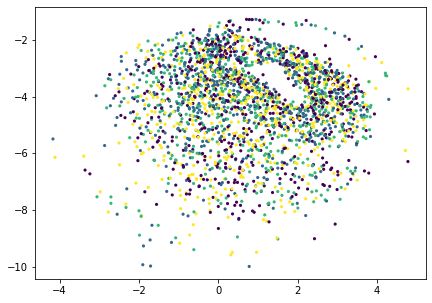

In [14]:
import umap.umap_ as umap
import matplotlib.pyplot as plt
%matplotlib inline

# Sur les données de retour de SVD (pas le mm nuage)
X_topics = svd.fit_transform(original_corpus_back_from_svd)
embedding = umap.UMAP(n_neighbors=150, min_dist=0.5, random_state=12).fit_transform(X_topics)

plt.figure(figsize=(7,5))
plt.scatter(embedding[:, 0], embedding[:, 1], 
            c = dataset.target,
            s = 10, # size
            edgecolor='none'
            )



## Analyse Kmeans

In [50]:
print("Nb clusters : ", true_k)

Nb clusters :  4


In [51]:
print(labels, )

[0 0 0 ... 0 0 0]


In [52]:
# #############################################################################
# clustering

try :
    if opts :
        option_minibatch=opts.minibatch
        verbose=opts.verbose
        nb_components= opts.n_components
except :
    option_minibatch=True
    verbose=False
    nb_components= True
    
print("Analyse par " + "Minibatch " if option_minibatch else "Kmeans") # Est vrai

if option_minibatch:
    km = MiniBatchKMeans(n_clusters=true_k, init='k-means++', n_init=1, batch_size=1000, verbose=verbose)
    #km = MiniBatchKMeans(n_clusters=true_k, init='k-means++', n_init=1,
    #                     init_size=1000, batch_size=1000, verbose=verbose)
else:
    km = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1, verbose=opts.verbose)

print("Données creuse de Clustering avec %s" % km)
t0 = time()
km.fit(reduced_lsa_corpus_TfIdf)
print("Fait en %0.3fs" % (time() - t0))
print()

Analyse par Minibatch 
Données creuse de Clustering avec MiniBatchKMeans(batch_size=1000, n_clusters=4, n_init=1, verbose=False)
Fait en 0.145s



In [54]:
print(f"{len(labels)} Labels : ", labels)
print(f"{len(km.labels_)} km.labels_ : ", km.labels_)

2352 Labels :  [0 0 0 ... 0 0 0]
2352 km.labels_ :  [0 0 2 ... 2 2 1]


### Quelques mesures propres au clustering et Kmeans

In [42]:
# Quelques mesures propres au clustering et Kmeans
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print(" Rand-Index ajusté : %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))
print("Coefficient Silhouette : %0.3f"
      % metrics.silhouette_score(original_corpus_back_from_svd, km.labels_, sample_size=1000))

print()


print("Meilleurs termes par cluster:")

if nb_components:
    original_space_centroids = svd.inverse_transform(km.cluster_centers_)
    #order_centroids = reduced_lsa_corpus_TfIdf
    order_centroids = original_space_centroids.argsort()[:, ::-1]
else:
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]

terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Homogeneity: 0.077
Completeness: 0.088
V-measure: 0.082
 Rand-Index ajusté : 0.040
Coefficient Silhouette : 0.004

Meilleurs termes par cluster:
Cluster 0: file windows files dos running use program run problem disk
Cluster 1: use just like new does don mac know apple mail
Cluster 2: thanks drive know problem does use like help hi window
Cluster 3: card video driver drivers ftp windows version cards thanks does


/Users/alex1/VirtEnv39-folder/virtenv39/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


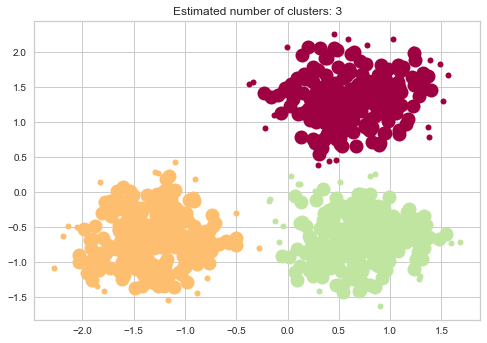

In [141]:
# Plot result
import matplotlib.pyplot as plt
n_clusters_ = len(set(km.labels_)) - (1 if -1 in labels else 0)
# Black removed and is used for noise instead.
unique_labels = set(km.labels_)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

### Pour kmeans

/var/folders/8w/4l60yjdd0vn27mdt01676qw40000gq/T/ipykernel_1173/2771317474.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


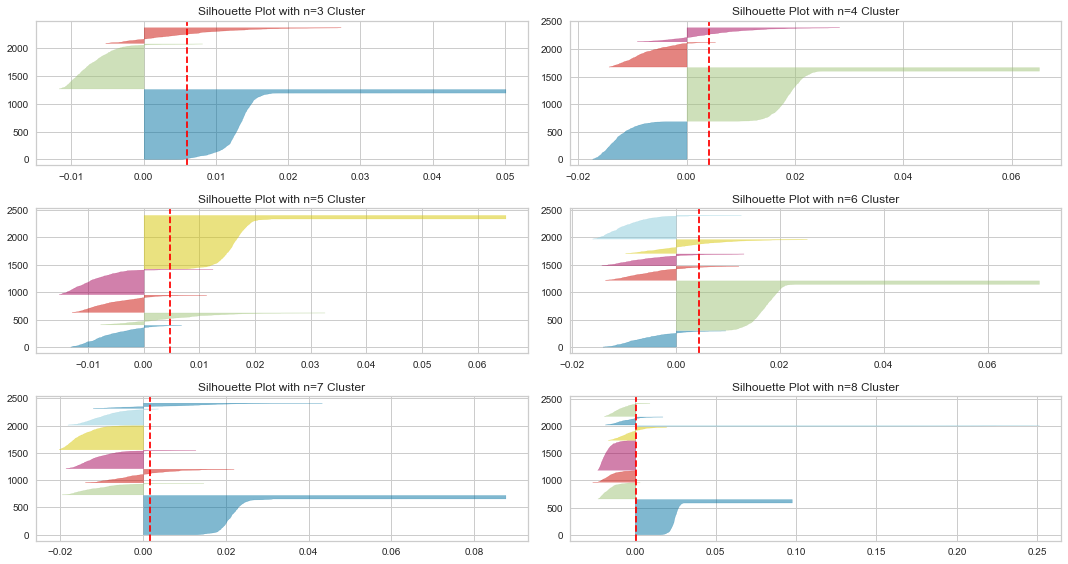

In [100]:
# Voir https://programminghistorian.org/en/lessons/clustering-with-scikit-learn-in-python#5-applying-dbscan-clustering-on-textual-data
def silhouettePlot(range_, data):
    '''
    we will use this function to plot a silhouette plot that helps us to evaluate the cohesion in clusters (k-means only)
    '''
    half_length = int(len(range_)/2)
    range_list = list(range_)
    fig, ax = plt.subplots(half_length, 2, figsize=(15,8))
    for _ in range_:
        kmeans = KMeans(n_clusters=_, random_state=42)
        q, mod = divmod(_ - range_list[0], 2)
        sv = SilhouetteVisualizer(kmeans, colors="yellowbrick", ax=ax[q][mod])
        ax[q][mod].set_title("Silhouette Plot with n={} Cluster".format(_))
        sv.fit(data)
    fig.tight_layout()
    fig.show() # avec inline, pas beoin ?
    fig.savefig("silhouette_plot.png")
    
silhouettePlot(range(3,9), reduced_lsa_corpus_TfIdf)

### A priori, Pour Kmeans, 4 clusters (correspond aux labels) 

# DBSCAN clustering

## Faisons un clustering DBscan

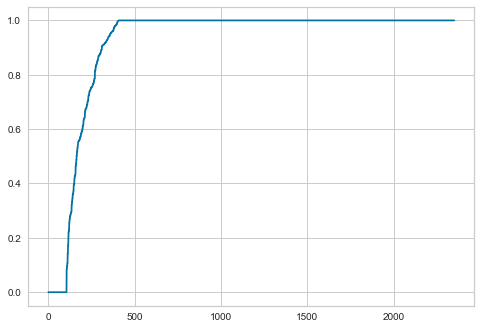

In [96]:
if False :
    !pip install seaborn    
    !pip install yellowbrick


from sklearn.preprocessing import StandardScaler as SS # z-score standardization 
from sklearn.cluster import KMeans, DBSCAN # clustering algorithms
from sklearn.decomposition import PCA # dimensionality reduction
from sklearn.metrics import silhouette_score # used as a metric to evaluate the cohesion in a cluster
from sklearn.neighbors import NearestNeighbors # for selecting the optimal eps value when using DBSCAN
import numpy as np

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.cluster import SilhouetteVisualizer
def findOptimalEps(n_neighbors, data):
    '''
    function to find optimal eps distance when using DBSCAN; based on this article: https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc
    '''
    neigh = NearestNeighbors(n_neighbors=n_neighbors)
    nbrs = neigh.fit(data)
    distances, indices = nbrs.kneighbors(data)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    plt.plot(distances)
    
findOptimalEps(2, reduced_lsa_corpus_TfIdf)

### La courbe montre que eps=1 est un bon compromis

In [139]:
from sklearn.cluster import DBSCAN



dbscan = DBSCAN(eps=0.65, min_samples=2).fit(reduced_lsa_corpus_TfIdf)
dbscan2  = DBSCAN(eps=1, min_samples=5).fit(reduced_lsa_corpus_TfIdf)
print(dbscan.labels_)
print(dbscan2.labels_)
#array([ 0,  0,  0,  1,  1, -1])

print("Comparaisons des labels ")
print("MEANS : ", np.average(km.labels_))
print("DBNSCAN : ", np.average(dbscan.labels_))
print("DBNSCAN2 : ", np.average(dbscan2.labels_))


[-1 -1 -1 ... -1 -1 -1]
[ 0 -1 -1 ... -1  0 -1]
Comparaisons des labels 
MEANS :  1.2206632653061225
DBNSCAN :  1.2963435374149659
DBNSCAN2 :  -0.3937074829931973


In [137]:
print(f"Les labels uniques (dbscan)=  {np.unique(dbscan.labels_)}")
print(f"Il y a  (dbscan)  {len(np.unique(dbscan.labels_))} labels ")

Les labels uniques =  [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70]
Il y a  72 labels 


In [138]:
print(f"Les labels uniques (dbscan2) =  {np.unique(dbscan2.labels_)}")
print(f"Il y a (dbscan2) {len(np.unique(dbscan2.labels_))} labels ")

Les labels uniques =  [-1  0]
Il y a  2 labels 


In [115]:
print(f"{len(labels)} Labels : ", labels) # labels = dataset.target
print(f"{len(km.labels_)} km.labels_ : ", km.labels_)

2352 Labels :  [0 0 0 ... 0 0 0]
2352 km.labels_ :  [0 0 2 ... 2 2 1]


In [116]:
#core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
#core_samples_mask[dbscan.core_sample_indices_] = True
#labels2 =dbscan.labels_
#labels2



array([-1, -1, -1, ..., -1, -1, -1])

In [122]:
print(f"{len(labels)} Labels : ", labels)
print(f"{len(km.labels_)} km.labels_ : ", km.labels_)
print(f"{len(dbscan.labels_)} dbscan.labels_ : ", dbscan.labels_)

2352 Labels :  [0 0 0 ... 0 0 0]
2352 km.labels_ :  [0 0 2 ... 2 2 1]
2352 dbscan.labels_ :  [-1 -1 -1 ... -1 -1 -1]


In [123]:

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, dbscan.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, dbscan.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, dbscan.labels_))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels, dbscan.labels_))
print("Adjusted Mutual Information: %0.3f" % metrics.adjusted_mutual_info_score(labels, dbscan.labels_))


Homogeneity: 1.000
Completeness: 0.000
V-measure: 0.000
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.000


### Le même code que ci-dessus (pour DBSCAN ici).
### En faire une focntion

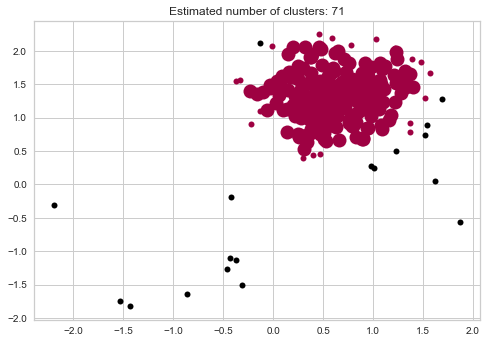

In [145]:
# Plot result
import matplotlib.pyplot as plt
n_clusters_ = len(set(dbscan.labels_)) - (1 if -1 in labels else 0) # On compte pas les labes négatifs !
# Black removed and is used for noise instead.
unique_labels = set(dbscan2.labels_)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

### <font color="red"> DBscan ne fonctionne pas bien sur ces données !! </font>

## Un autre ex dbscan (qui se passe bien) sur des données générées

Estimated number of clusters: 3
Estimated number of noise points: 18
Homogeneity: 0.953
Completeness: 0.883
V-measure: 0.917
Adjusted Rand Index: 0.952
Adjusted Mutual Information: 0.916
Silhouette Coefficient: 0.626


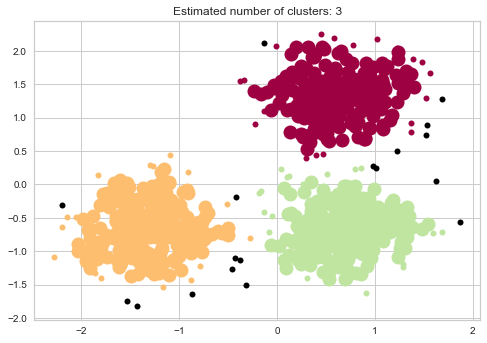

In [124]:
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler


# #############################################################################
# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(
    n_samples=750, centers=centers, cluster_std=0.4, random_state=0
)

X = StandardScaler().fit_transform(X)

# #############################################################################
# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
print(
    "Adjusted Mutual Information: %0.3f"
    % metrics.adjusted_mutual_info_score(labels_true, labels)
)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()